### DM data science task

Dataset contains list of series of measurements of air pressure provided by Air Pump, where in some cases Pump failed and in some cases not. Goal is to build a predictive model that will predict whether Pump worked fine or not.  

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

DATA_PATH = r'C:\Users\pacak\Downloads\data\data.parquet'
LABELS_PATH = r'C:\Users\pacak\Downloads\data\labels.csv'

import numpy as np

np.random.seed(42)

import seaborn as sns
from sklearn.metrics import roc_auc_score

from datamole_airpressure.common.metrics import Metrics
from datamole_airpressure.common.plots import show_series, visualise_feature
from datamole_airpressure.tabular.feature_extraction import FeatureExtractor
from datamole_airpressure.tabular.feature_extraction_config import \
    feature_config
from datamole_airpressure.tabular.lgbm_model import LGBMModel
from datamole_airpressure.tabular.lgbm_model_config import params as config

In [2]:
data =  pd.read_parquet(DATA_PATH, engine='pyarrow')
labels = pd.read_csv(LABELS_PATH)

# Target distribution

False    0.874858
True     0.107431
NaN      0.017710
Name: PumpFailed, dtype: float64

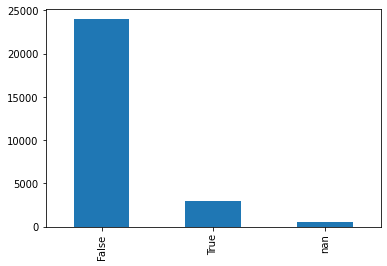

In [3]:
labels['PumpFailed'].value_counts(dropna = False).plot(kind='bar')
labels['PumpFailed'].value_counts(dropna = False)/len(labels)

There are some measurements where is unknownow whether Pump failed or not, therefore we wil drop these measurements 

In [4]:
labels = labels[labels['PumpFailed'].notnull()].reset_index(drop = True)

In [5]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_2,0,False,False,False
2,0_0_3,0,True,False,False
3,0_1_1,1,True,False,False
4,1_0_0,2,False,True,False


### Train/ Test split of the labels
With the ration 70% od data to train and 30% of data to test.

In [6]:
labels['random'] = np.random.random(size=len(labels))
labels_train = labels[labels['random']<=0.7].reset_index(drop = True)
labels_test = labels[labels['random']>0.7].reset_index(drop =True)

In [7]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,random
0,0_0_0,0,False,False,False,0.374540
1,0_0_2,0,False,False,False,0.950714
2,0_0_3,0,True,False,False,0.731994
3,0_1_1,1,True,False,False,0.598658
4,1_0_0,2,False,True,False,0.156019


### Plot 2 measurements with Pupfailed = False

machine_id: 0_0_0, measurement_id:0
No observatons:
(368,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd   random
0     0_0_0              0      False     False   False  0.37454


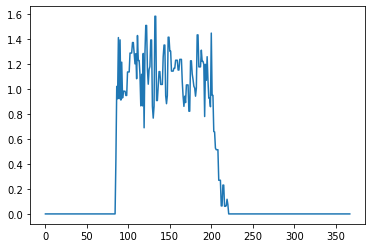

In [8]:
show_series(data, labels, '0_0_0', 0)

machine_id: 0_0_2, measurement_id:0
No observatons:
(368,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
1     0_0_2              0      False     False   False  0.950714


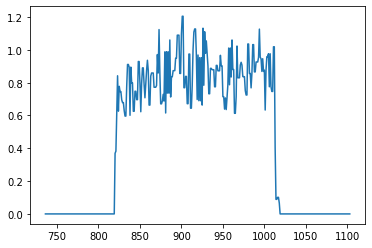

In [9]:
show_series(data, labels, '0_0_2', 0)

### Plot 2 measurements with Pupfailed = True

machine_id: 0_0_3, measurement_id:0
No observatons:
(368,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
2     0_0_3              0       True     False   False  0.731994


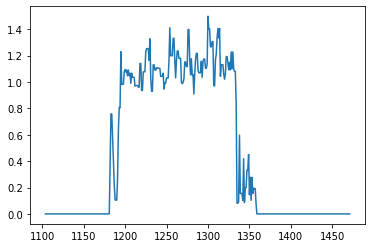

In [10]:
show_series(data, labels, '0_0_3', 0)

machine_id: 0_1_1, measurement_id:1
No observatons:
(353,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
3     0_1_1              1       True     False   False  0.598658


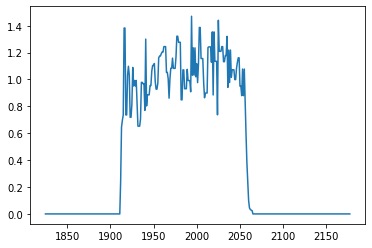

In [11]:
show_series(data, labels, '0_1_1', 1 )

With human eye it is not clearly visible at the first look which series is with Failed Pump and which not.
Series with MachineId '0_0_3' and MeasurementID 0, there is quite nicely visible rapid non-zero drop in the end, but on the other hand, the measurements from the last chart are for human eye without any PumpFailed pattern.    

#### Distribution of counts of individual data points within different  MeasurementIds

Average number of measurements is 490.52167286245356
Median number of measurements is 436.0


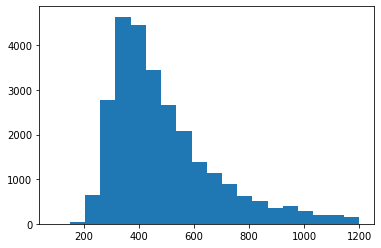

In [12]:
# Measurementsid -1 corresponds to thhe data without labels 
pressure_counts = data[data['MeasurementId']!=-1].groupby(['MachineId', 'MeasurementId']).count()['Pressure'].values
plt.hist(pressure_counts, bins = 20 )
print(f'Average number of measurements is {np.mean(pressure_counts)}')
print(f'Median number of measurements is {np.median(pressure_counts)}')

Usually there is about 490 data points in one Measurements 

## Extraction of statistical featues from measurements
For the purpose of building of ML model, that will predict whether Pump failed or not, based on the measurement values, first it is necessary to extract several statistical features from measurements.

I have extracted 4 types of the feature:
* statistics from raw data.
* statistics non-zero data (data from the beginning and end, where the values are 0 are excluded). These feature will have 'non-zero' in the names, end.
* statisticts from series created as differences between consecutive values. It means that value of the series at time t is calculated as value time T+1 minus value at time T. These features have '_lagged' in the end of the name.
* statisticts from series created as in the absolute values from the series created as in previous step. These features have '_lagged_abs' in the names' ending. 

In [13]:
# Config file imported
feature_config

{'feature_mean': True,
 'feature_median': True,
 'feature_max': True,
 'feature_min': True,
 'feature_kurtosis': True,
 'feature_skew': True,
 'feature_max_min_diff': True,
 'feature_sum': True,
 'feature_mean_non_zero': True,
 'feature_median_non_zero': True,
 'feature_max_non_zero': True,
 'feature_min_non_zero': True,
 'feature_kurtosis_non_zero': True,
 'feature_skew_non_zero': True,
 'feature_max_min_diff_non_zero': True,
 'feature_sum_non_zero': True,
 'feature_mean_lagged': True,
 'feature_median_lagged': True,
 'feature_max_lagged': True,
 'feature_min_lagged': True,
 'feature_kurtosis_lagged': True,
 'feature_skew_lagged': True,
 'feature_max_min_diff_lagged': True,
 'feature_sum_lagged': True,
 'feature_mean_lagged_abs': True,
 'feature_median_lagged_abs': True,
 'feature_min_lagged_abs': True,
 'feature_kurtosis_lagged_abs': True,
 'feature_skew_lagged_abs': True,
 'feature_max_min_diff_lagged_abs': True,
 'feature_sum_lagged_abs': True}

In [14]:
feature_extractor = FeatureExtractor(feature_config)
data_features = feature_extractor.run(data)

In [15]:
# Bit of data preprocessing, I did not to create any special function for that

# Merge features to train and test data
train_data = pd.merge(labels_train, data_features, how = 'inner', left_on = ['MachineId', 'MeasurementId'],
                             right_on = ['MachineId', 'MeasurementId'])
test_data = pd.merge(labels_test, data_features, how = 'inner', left_on = ['MachineId', 'MeasurementId'],
                             right_on = ['MachineId', 'MeasurementId'])

train_target = train_data['PumpFailed'].astype('int')
test_target = test_data['PumpFailed'].astype('int')

preds = [key for key in feature_config.keys() if feature_config[key]]
for col in preds:
    train_data[col] = train_data[col].astype('float')
    test_data[col] = test_data[col].astype('float')  

### EDA - Individual sorting power of the predictors

Visualise and print individual sorting power of the created features.

Note: For individual AUC holds assumption is that the relationship between target and feature is linear.

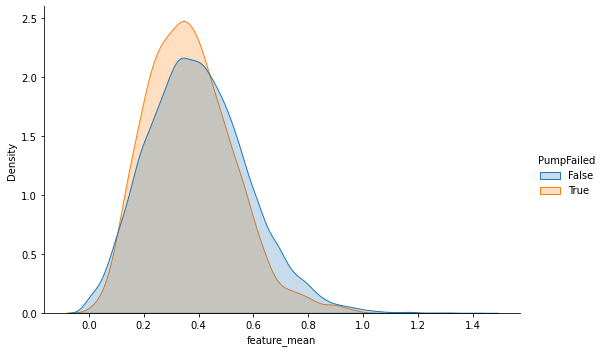

Individual AUC performance of the feature: 0.5483900192342834 


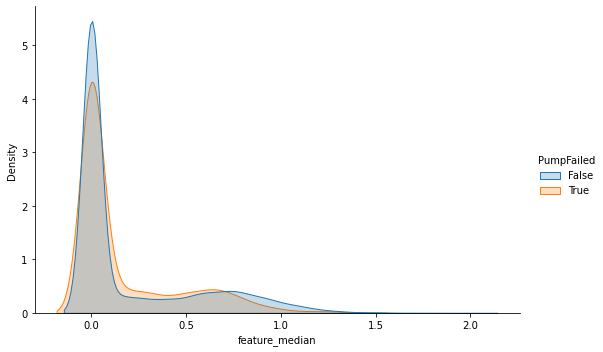

Individual AUC performance of the feature: 0.5032585832430813 


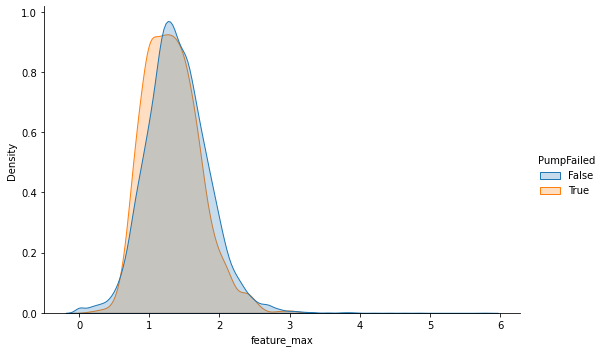

Individual AUC performance of the feature: 0.554135009596493 


Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


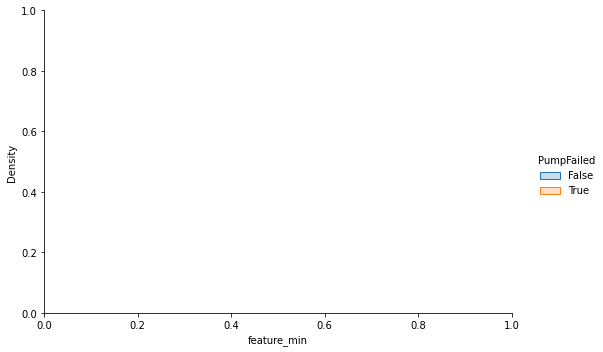

Individual AUC performance of the feature: 0.5 


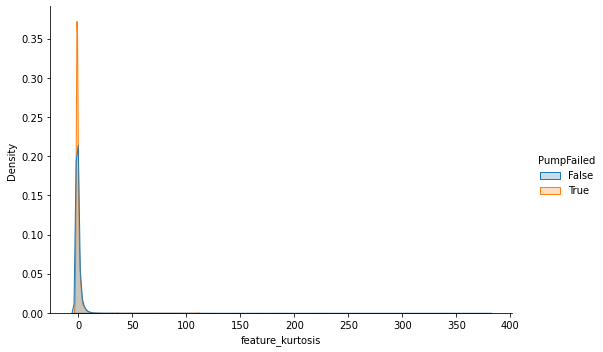

Individual AUC performance of the feature: 0.5245516445731089 


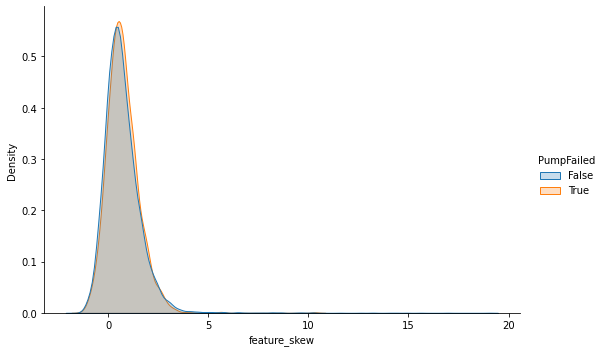

Individual AUC performance of the feature: 0.5229563014561822 


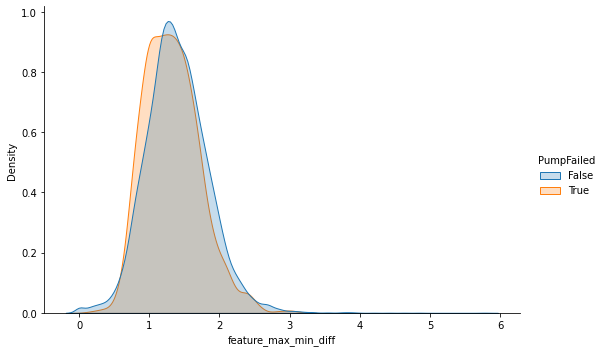

Individual AUC performance of the feature: 0.554135009596493 


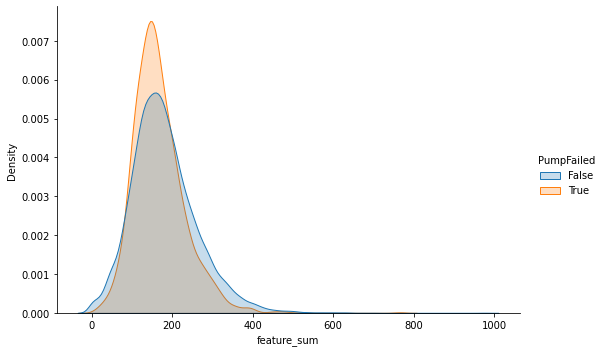

Individual AUC performance of the feature: 0.5465764306093426 


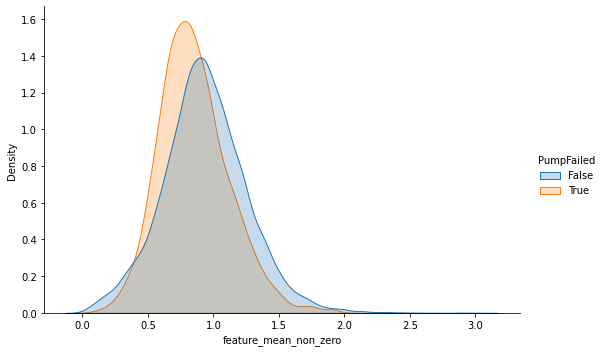

Individual AUC performance of the feature: 0.5872279741647496 


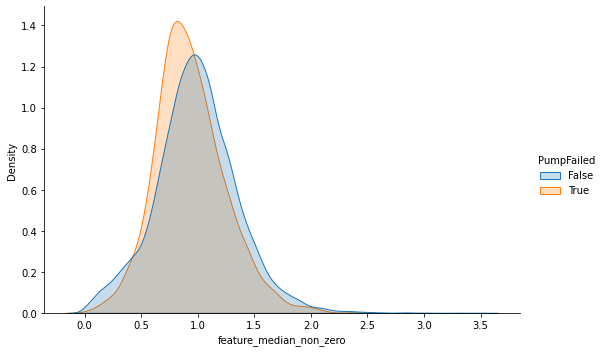

Individual AUC performance of the feature: 0.5558012871864909 


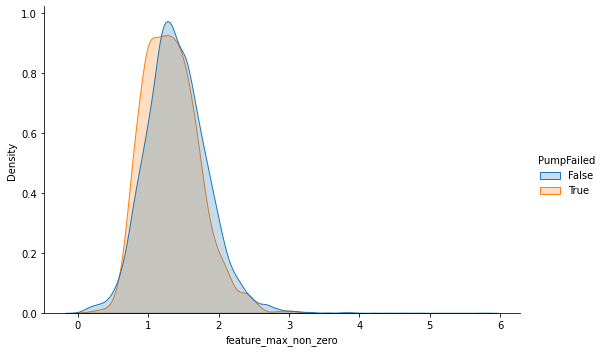

Individual AUC performance of the feature: 0.5553933537081619 


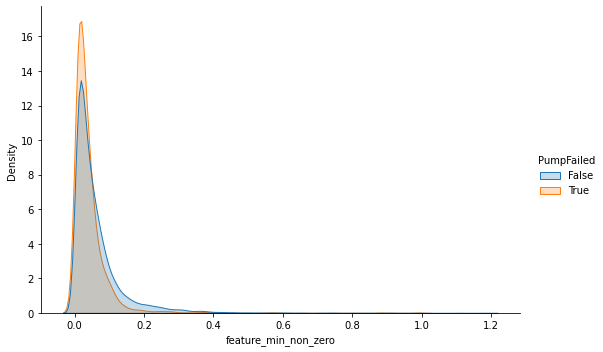

Individual AUC performance of the feature: 0.6023636801693453 


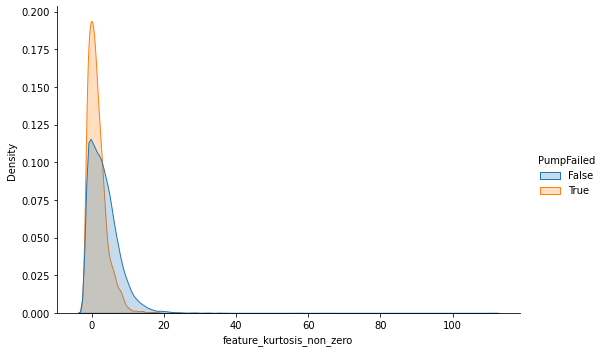

Individual AUC performance of the feature: 0.6458397827466789 


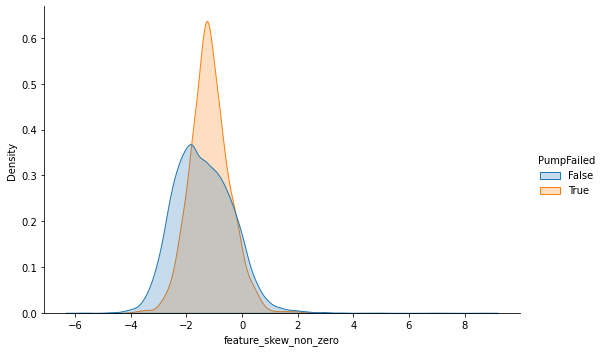

Individual AUC performance of the feature: 0.5809638152771892 


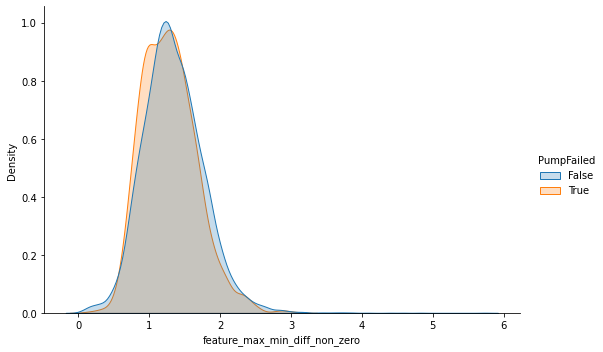

Individual AUC performance of the feature: 0.5407030632320462 


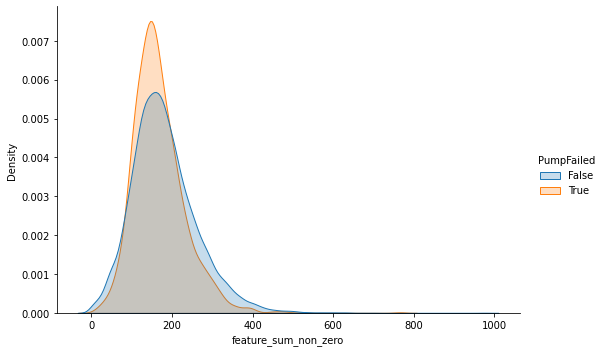

Individual AUC performance of the feature: 0.5478176105043561 


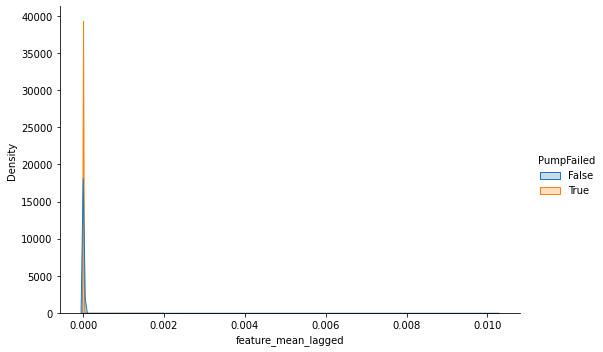

Individual AUC performance of the feature: 0.5074903378325749 


Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


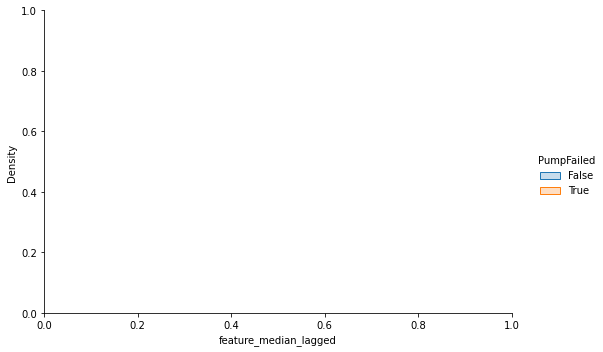

Individual AUC performance of the feature: 0.5 


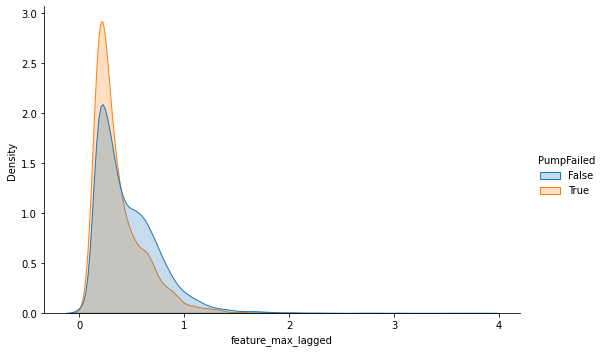

Individual AUC performance of the feature: 0.6005121657101147 


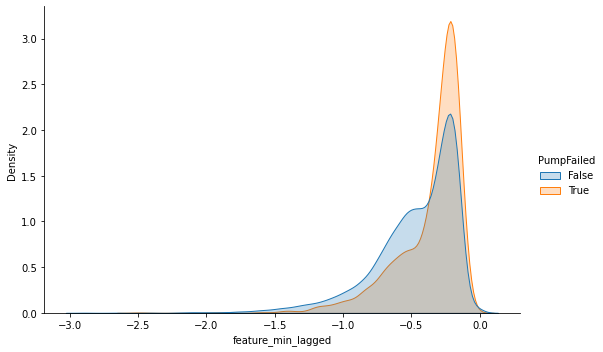

Individual AUC performance of the feature: 0.6118480553550908 


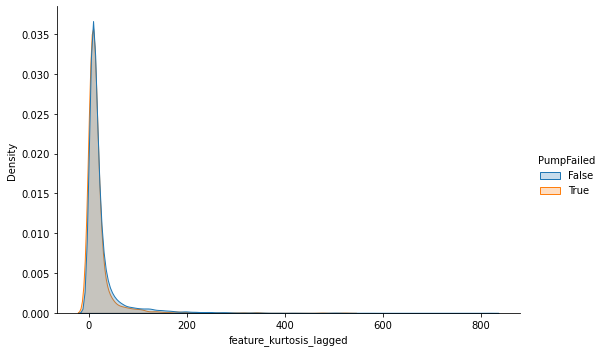

Individual AUC performance of the feature: 0.5676703895163233 


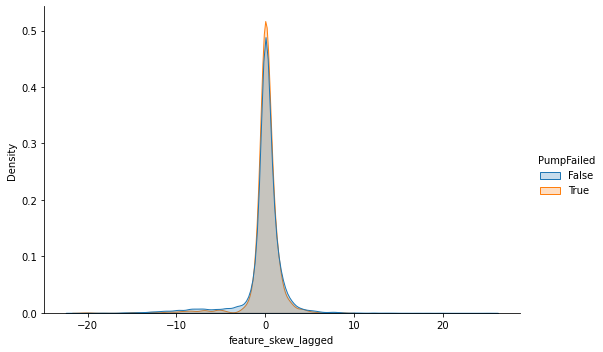

Individual AUC performance of the feature: 0.5049540296380267 


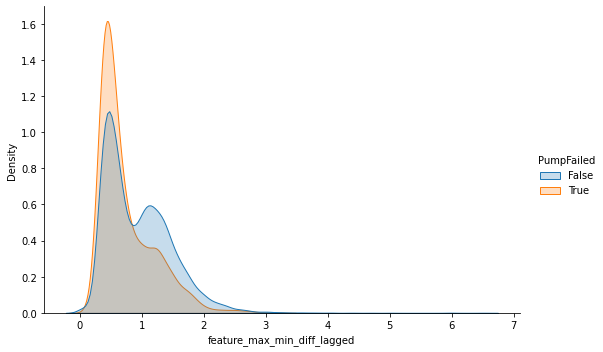

Individual AUC performance of the feature: 0.616299532409716 


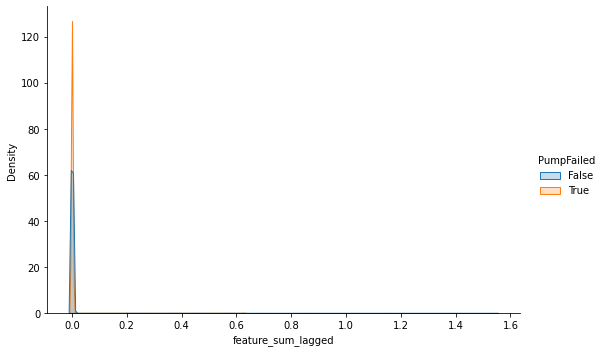

Individual AUC performance of the feature: 0.5076197938408765 


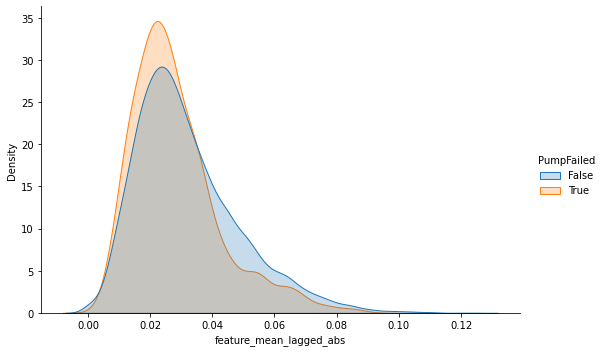

Individual AUC performance of the feature: 0.5654811949231219 


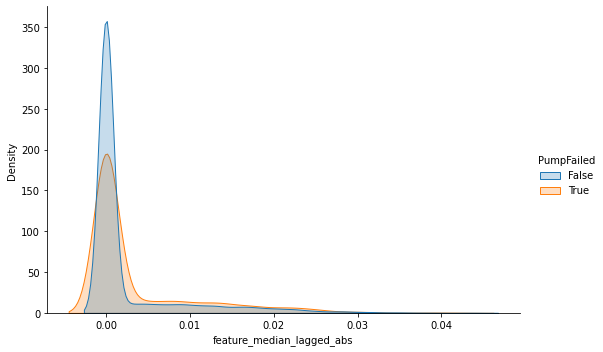

Individual AUC performance of the feature: 0.5395684985179381 


Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


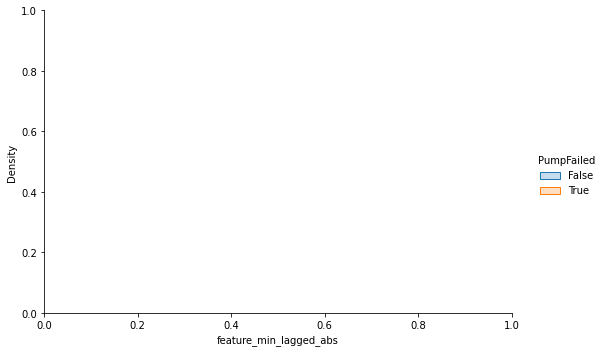

Individual AUC performance of the feature: 0.5 


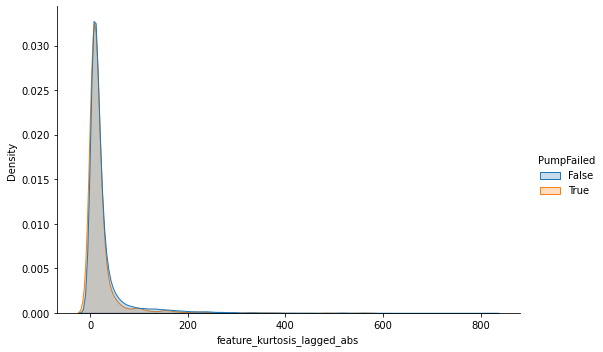

Individual AUC performance of the feature: 0.5670660702857221 


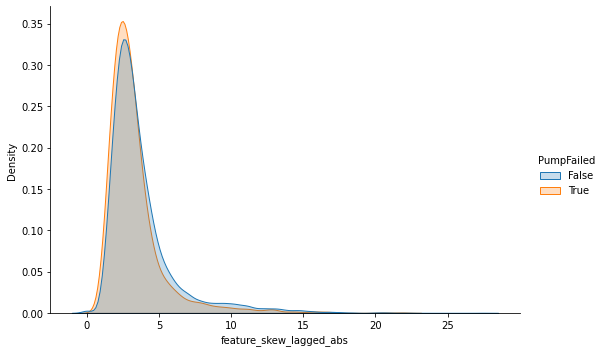

Individual AUC performance of the feature: 0.5669360120230619 


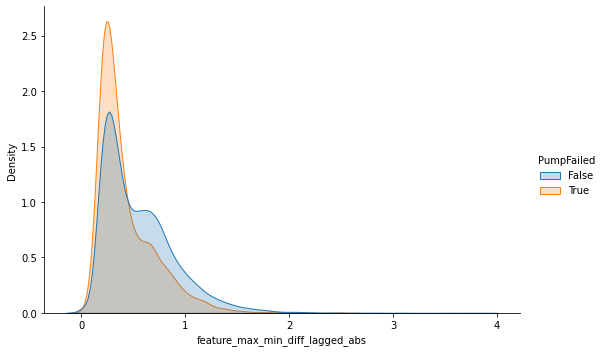

Individual AUC performance of the feature: 0.6176989421086726 


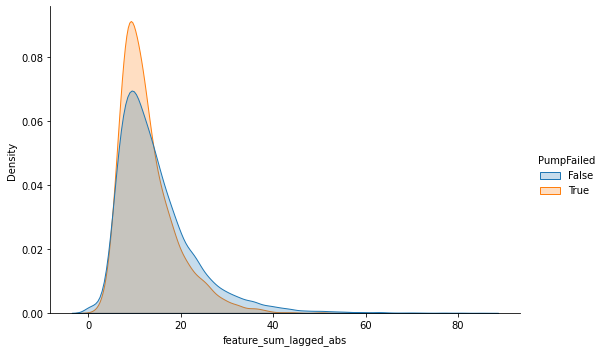

Individual AUC performance of the feature: 0.5554906124605623 


In [16]:
for col in preds:
    visualise_feature(train_data, col, 'PumpFailed')

It is visible that those features has some distrimination power, althought it is not super strong. Lets blend them into Machine learning model.

### ML model - LGBM

Predictive model - LGBM
LGBM is newer implementation of famous XGBoost algorithm. Trained model is ensemble of many decision trees (usually), where every next decision tree is trained with (pseudo)residuals as a target variable from previous decion trees. Final prediction is then made as average of these decision trees.

LGBM implementation has few advantages over XGBoost - it can handle categorical variables implicitly (you do not need OHE), training of the model is much faster, etc. The results are usually pretty similar.

Fitting of decision trees requires less data preparation than for example logistic regression, where linear relationship between target and variables is demanded. For example I do not have to care about quadratic relationship between age and target, because decision trees can handle it pretty fine. Therefore I do not need to care much about data preprocessing right now (i am not saying, that is never necessary). Next big advantage of decion trees is that in a similar way as nonlinearity implicitely finds interactions between variables. In the linear models you will never find interactions, unless you will create them manually.

Disadvantage of these algorithms is that they are often harder to explain then linear models, where the whole model can be written as equation.

In [17]:
# print imported comfig for the lgbm model
config

{'num_boost_round': 100000,
 'early_stopping_rounds': 200,
 'learning_rate': 0.01,
 'metric': 'auc',
 'objective': 'binary',
 'seed': 1234,
 'verbose': 1}

In [18]:
lgbm_model = LGBMModel(config)
model, valid_data, valid_target = lgbm_model.fit(train_data[preds], train_target)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[472]	valid_0's auc: 0.786196


Performance of the validation set (taken as 30% of the training set) was almost 0.8 AUC

#### Print most important features in the model according to the 'gain' importance

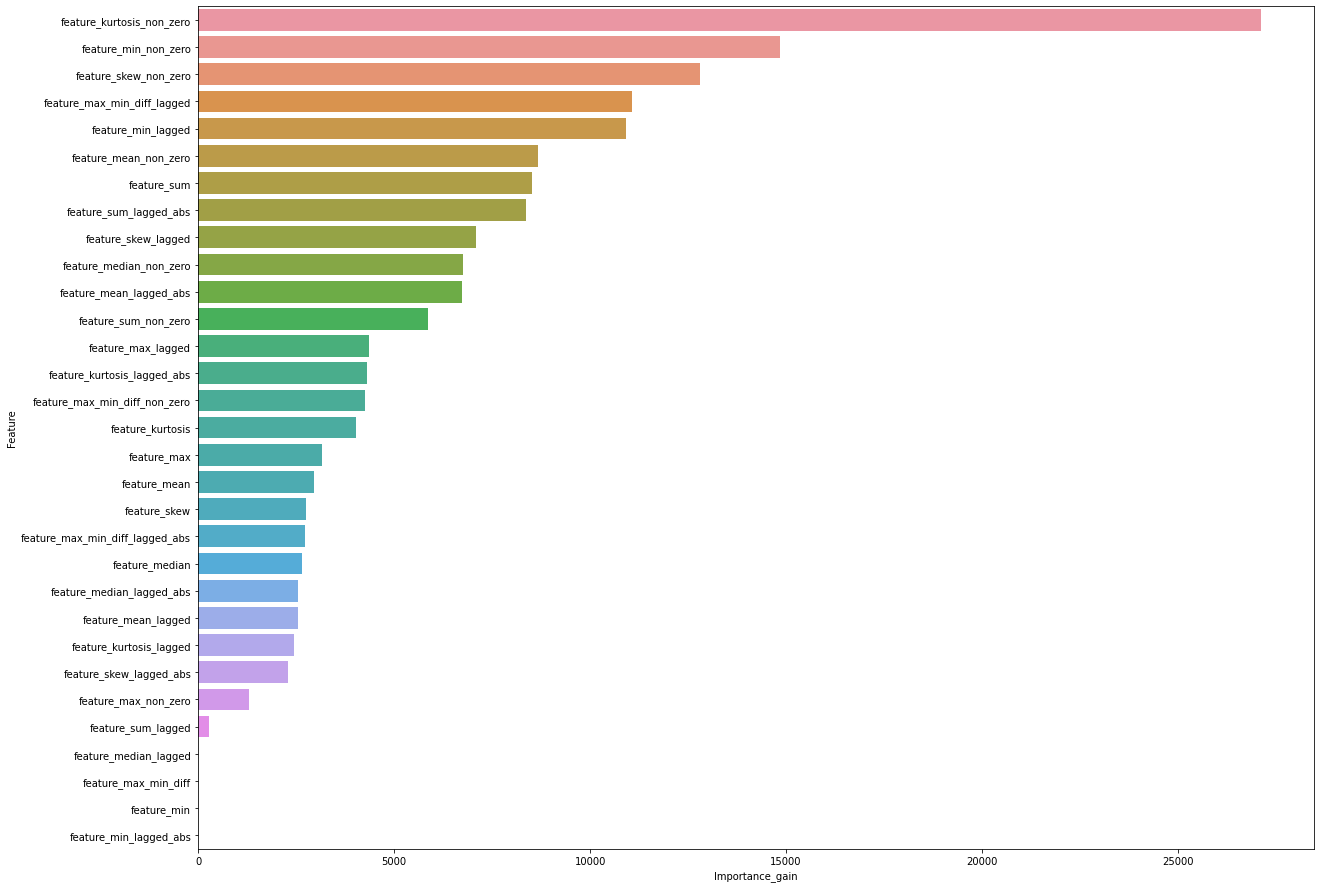

In [19]:
lgbm_model.plot_importance([model], preds)

#### Feature selection

Last 4 predictors are not used by algorithm at all, train model again to keep it leaner with hopefully same performance.

Note: Of course, it would be possible, to provide a bit more sophisticated feature selection process, at least as droping the features one by one and checking validation performance. But to keep this notebook still readable with not skipping any single step in model development, then keep this procedure a bit simpler with only removing those last four features, while keeping the rest as selected to the final model.

In [20]:
for col in ['feature_min', 'feature_min_lagged_abs', 'feature_median_lagged', 'feature_max_min_diff']:
    preds.remove(col)

In [21]:
lgbm_model = LGBMModel(config)
model, valid_data, valid_target = lgbm_model.fit(train_data[preds], train_target)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[541]	valid_0's auc: 0.797996


Performance with leaner model almost did not change.

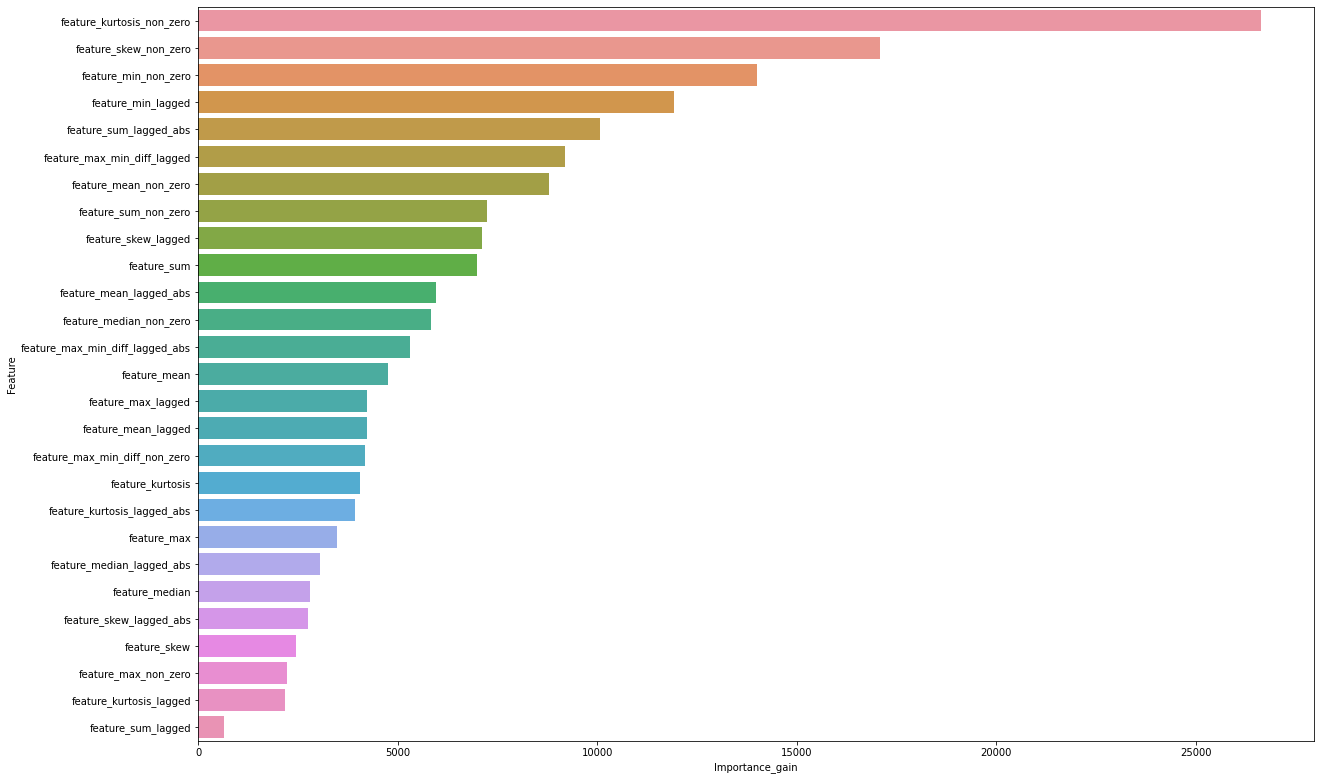

In [22]:
lgbm_model.plot_importance([model], preds)

## Valid data evaluation

Moreover to the evaluation of the algorithm through its sorting power (auc metric), maybe we would like to predict actual label category- whether Pump failed or Not. This is a bit more tricky task, then only prediction of the probabilities of the model, because there needs to be set a threshold, based on which can be decided whether Pump failed or not. 

Because it is not fully know from the use case whether our aim is to maximize recall or precision (depends how much we care about having lot of false positive cases), we will try to set the threshold based on validation data that will optimize so-call F1 score - metric between 0-1, that takes into account balance between precision and recall.

In [ ]:
valid_metrics = Metrics(valid_target, lgbm_model.predict(valid_data, model))
valid_metrics.calculate_stats()

Plot F1-score as a function of threshold for validation data

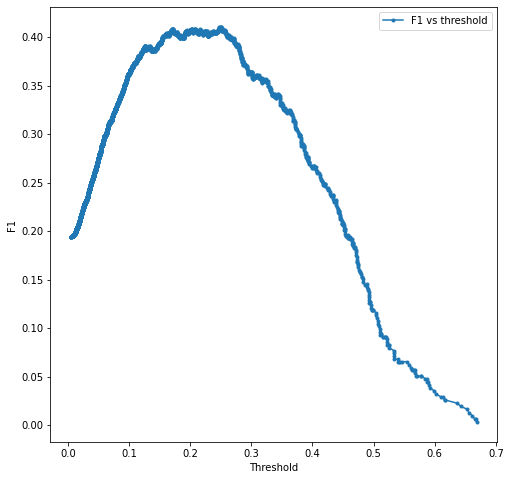

In [24]:
valid_metrics.plot_F1_vs_threshold()

In [25]:
print(f'Optimal threshold is {valid_metrics.threshold}')
threshold_to_use = valid_metrics.threshold

Optimal threshold is 0.25008257024590325


In [26]:
valid_metrics.calculate_label_predictions()
valid_metrics.print_all_metrics()

Area under ROC curve:
0.797996045708924
F1 score:
0.40938511326860844
Precision
0.40350877192982454
Recall:
0.4154351395730706
Confusion Matrix:
[[4673  374]
 [ 356  253]]


## Test data evaluation

Evaluating completely unseen testing data. The threshold for label classification is selected the one from the validation data. 

In [27]:
test_metrics = Metrics(test_target, lgbm_model.predict(test_data[preds], model), threshold = threshold_to_use)

In [28]:
test_metrics.calculate_label_predictions()
test_metrics.print_all_metrics()

Area under ROC curve:
0.7876568285377871
F1 score:
0.3922241280731847
Precision
0.3871331828442438
Recall:
0.39745075318655854
Confusion Matrix:
[[6643  543]
 [ 520  343]]


We can see that all the metrics are for the test set similar as for the validation set, which is good sign that the model shouldn't be overfitted. Both metrics, AUC score and F1 score are indicating good, but not excellent classification power of the algorithm. 

Please check computer vision approach, where I am trying to improve this performance with completely different approch. 

## Explanation of the model - SHAP values

Importance of the features based on SHAP values
Shap values is superpowerful method that gives us contribution to the predicted outcome of each variable for every single observation. Therefore it brings local interpretability to every prediction and makes this model less 'black-box'.

Variables are sorted according their mean absolute impact on the prediction. And the SHAP value on x-axis means difference contribution to the prediction - average prediction in logits.

SHAP dependence plot shows real relation between variable and prediction and with this tool one can check that the variable in the model behaves similarly as is expected for example from EDA.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


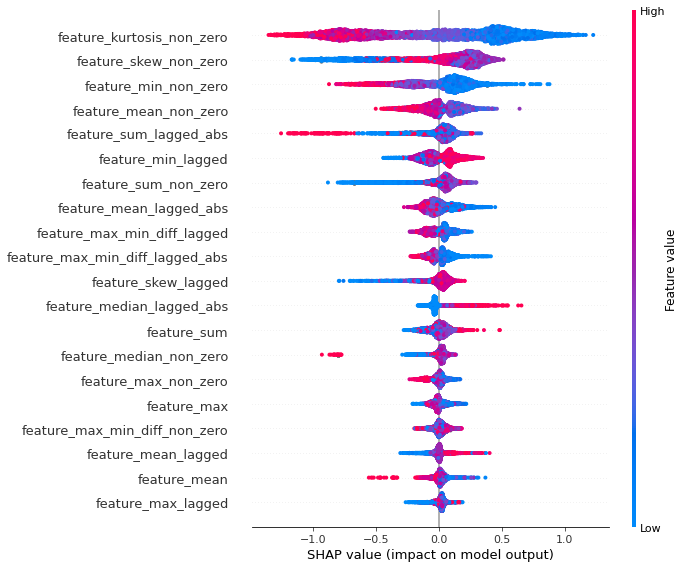

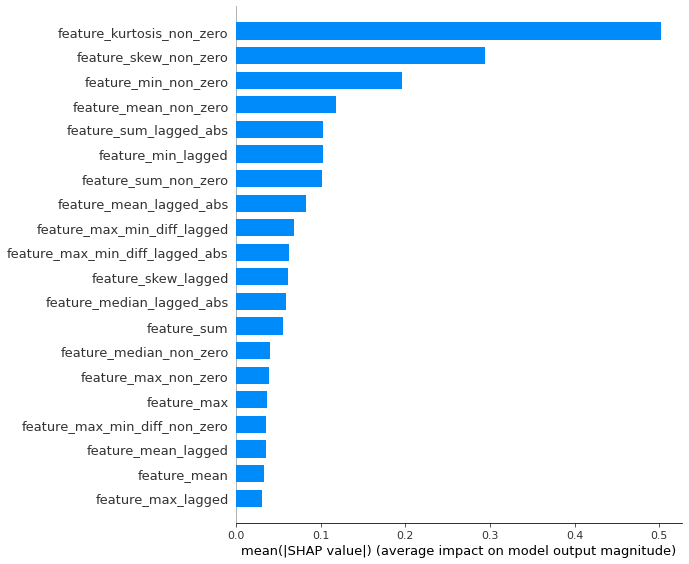

In [31]:
lgbm_model.print_shap_values(model, valid_data)

We can see that the variable importance from SHAP method fairly corresponds to the global 'importance_gain' method that is completely inherited during training of the model.

We can see that for some features (for example 'feature_skew_non_zero' or 'feature_sum_lagged_abs'), there is not smooth transition between blue and red dots. This indicates that the model learned some nonlinear patterns from these features.
Lets have a deeper look to these features with dependence plots.

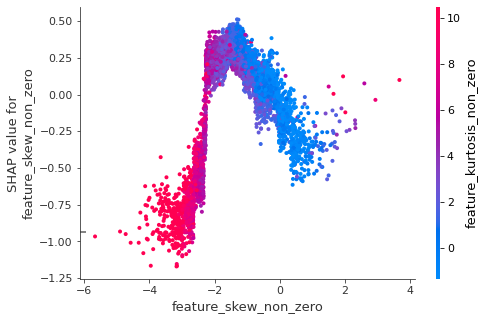

In [30]:
lgbm_model.shap_dependence_plot(valid_data, 'feature_skew_non_zero')

From the dependence plot for 'feature_skew_non_zero', it is visible, that if the values of the feature afre from the middle of its distribution, then it is more likely, that the Pump will fail, and if the values are low or high, the the chance for Pumpfail is getting smaller.

Take a look that this completely corresponds to the EDA chart for this feature. 

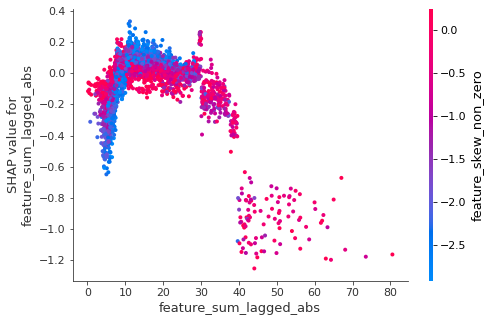

In [32]:
lgbm_model.shap_dependence_plot(valid_data, 'feature_sum_lagged_abs')

Same case as the previous feature.